# Custom Model 1

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive'

In [0]:
cd drive/My Drive/

In [9]:
!pip install torchnet

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

image_transformed_crops = 144
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'XRAY': transforms.Compose([
        transforms.RandomResizedCrop(image_transformed_crops),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'kusal_set'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['XRAY']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['XRAY']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['XRAY']}
class_names = image_datasets['XRAY'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
class_names

['NOFRACTURES', 'WITHFRACTURES']

# View Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


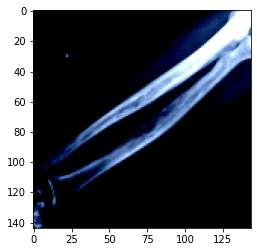

In [18]:
arr_ = image_datasets['XRAY'][6][0].T
plt.imshow(arr_)
plt.show()

In [0]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

In [21]:
!pip install tqdm

In [0]:
from tqdm import tqdm
#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['XRAY']:
            if phase == 'XRAY':
                scheduler.step()
                model.train()  # Set model to training mode
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'XRAY'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'XRAY':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "XRAY":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
    

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing        
            if phase == "XRAY":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'XRAY' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Traning Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [29]:
torch.cuda.empty_cache()
# Transfer antinodes from VGG16-Oxford University
model_ft = models.vgg16_bn(pretrained=True)
model_ft.classifier[6].out_features = 8
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Using Adam as the parameter optimizer
# optimizer_ft = optim.Adam(model_ft.parameters(), lr = 0.001, betas=(0.9, 0.999))
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001, lr_decay=0, weight_decay=0.001, initial_accumulator_value=0, eps=1e-10)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)       

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


  0%|          | 0/85 [00:00<?, ?it/s]

Epoch 1/30
----------




  1%|          | 1/85 [00:00<00:42,  1.99it/s]

  2%|▏         | 2/85 [00:00<00:32,  2.52it/s]

  4%|▎         | 3/85 [00:00<00:25,  3.22it/s]

  5%|▍         | 4/85 [00:00<00:20,  4.00it/s]

  6%|▌         | 5/85 [00:00<00:16,  4.84it/s]

  7%|▋         | 6/85 [00:01<00:13,  5.68it/s]

  8%|▊         | 7/85 [00:01<00:12,  6.45it/s]

  9%|▉         | 8/85 [00:01<00:10,  7.16it/s]

 11%|█         | 9/85 [00:01<00:09,  7.79it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.96it/s]

 13%|█▎        | 11/85 [00:01<00:08,  8.29it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.52it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.75it/s]

 16%|█▋        | 14/85 [00:01<00:08,  8.83it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.88it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.82it/s]

 20%|██        | 17/85 [00:02<00:07,  9.14it/s]

 21%|██        | 18/85 [00:02<00:07,  9.17it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.23it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.23it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 1.0770 Acc: 0.6214

Epoch 2/30
----------




  1%|          | 1/85 [00:00<00:52,  1.59it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.13it/s]

  4%|▎         | 3/85 [00:00<00:29,  2.75it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.47it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.22it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.00it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.67it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.37it/s]

 11%|█         | 9/85 [00:01<00:10,  6.97it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.58it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.89it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.19it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.37it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.58it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.82it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.97it/s]

 20%|██        | 17/85 [00:02<00:07,  9.03it/s]

 21%|██        | 18/85 [00:02<00:07,  8.96it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.18it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.16it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.4791 Acc: 0.7936

Epoch 3/30
----------




  1%|          | 1/85 [00:00<00:53,  1.57it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.10it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.71it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.44it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.21it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.01it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.79it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.44it/s]

 11%|█         | 9/85 [00:01<00:11,  6.72it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.38it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.87it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.30it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.39it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.64it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.73it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.81it/s]

 20%|██        | 17/85 [00:02<00:07,  8.89it/s]

 21%|██        | 18/85 [00:02<00:07,  8.92it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.00it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.18it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.4146 Acc: 0.8211

Epoch 4/30
----------




  1%|          | 1/85 [00:00<00:41,  2.01it/s]

  2%|▏         | 2/85 [00:00<00:33,  2.47it/s]

  4%|▎         | 3/85 [00:00<00:26,  3.14it/s]

  5%|▍         | 4/85 [00:00<00:20,  3.94it/s]

  6%|▌         | 5/85 [00:01<00:16,  4.76it/s]

  7%|▋         | 6/85 [00:01<00:14,  5.46it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.38it/s]

 11%|█         | 9/85 [00:01<00:10,  7.12it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.49it/s]

 13%|█▎        | 11/85 [00:01<00:09,  8.06it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.57it/s]

 16%|█▋        | 14/85 [00:02<00:13,  5.44it/s]

 18%|█▊        | 15/85 [00:02<00:11,  6.18it/s]

 19%|█▉        | 16/85 [00:02<00:09,  6.92it/s]

 21%|██        | 18/85 [00:02<00:08,  7.58it/s]

 22%|██▏       | 19/85 [00:02<00:08,  8.01it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.40it/s]

 25%|██▍       | 21/85 [00:02<00:07,  8.76it/s]

 26%|██▌       | 22/85 [00:03<00:07,  8.89it/s]

 27%|██▋       | 23/85 [00:03<00:06,  8.98it/s]

 28%|██▊       | 24/85 [00

XRAY Loss: 0.4033 Acc: 0.8226

Epoch 5/30
----------




  1%|          | 1/85 [00:00<00:44,  1.88it/s]

  2%|▏         | 2/85 [00:00<00:34,  2.42it/s]

  4%|▎         | 3/85 [00:00<00:26,  3.13it/s]

  5%|▍         | 4/85 [00:00<00:20,  3.86it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.26it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.14it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.98it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.76it/s]

 11%|█         | 9/85 [00:01<00:10,  7.14it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.72it/s]

 13%|█▎        | 11/85 [00:01<00:09,  8.04it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.30it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.60it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.56it/s]

 18%|█▊        | 15/85 [00:02<00:12,  5.40it/s]

 19%|█▉        | 16/85 [00:02<00:11,  6.23it/s]

 20%|██        | 17/85 [00:02<00:10,  6.75it/s]

 21%|██        | 18/85 [00:02<00:09,  7.36it/s]

 22%|██▏       | 19/85 [00:02<00:08,  7.65it/s]

 24%|██▎       | 20/85 [00:02<00:08,  8.08it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.3539 Acc: 0.8523

Epoch 6/30
----------




  1%|          | 1/85 [00:00<00:59,  1.41it/s]

  4%|▎         | 3/85 [00:00<00:43,  1.89it/s]

  5%|▍         | 4/85 [00:01<00:32,  2.50it/s]

  6%|▌         | 5/85 [00:01<00:25,  3.19it/s]

  7%|▋         | 6/85 [00:01<00:20,  3.92it/s]

  8%|▊         | 7/85 [00:01<00:16,  4.75it/s]

  9%|▉         | 8/85 [00:01<00:14,  5.49it/s]

 11%|█         | 9/85 [00:01<00:12,  6.24it/s]

 12%|█▏        | 10/85 [00:01<00:10,  6.91it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.44it/s]

 14%|█▍        | 12/85 [00:01<00:09,  7.84it/s]

 15%|█▌        | 13/85 [00:02<00:08,  8.17it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.38it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.75it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.87it/s]

 20%|██        | 17/85 [00:02<00:07,  9.09it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.39it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.24it/s]

 26%|██▌       | 22/85 [00:02<00:06,  9.57it/s]

 27%|██▋       | 23/85 [00:03<00:06,  9.47it/s]

 28%|██▊       | 24/85 [00

XRAY Loss: 0.3744 Acc: 0.8500

Epoch 7/30
----------




  1%|          | 1/85 [00:00<00:53,  1.56it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.08it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.71it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.44it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.20it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.92it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.66it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.29it/s]

 11%|█         | 9/85 [00:01<00:11,  6.89it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.19it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.73it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.20it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.51it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.65it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.61it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.81it/s]

 20%|██        | 17/85 [00:02<00:07,  8.78it/s]

 21%|██        | 18/85 [00:02<00:07,  9.09it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.32it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.12it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.3218 Acc: 0.8782

Epoch 8/30
----------




  1%|          | 1/85 [00:00<00:54,  1.53it/s]

  2%|▏         | 2/85 [00:00<00:40,  2.03it/s]

  4%|▎         | 3/85 [00:00<00:31,  2.64it/s]

  5%|▍         | 4/85 [00:01<00:24,  3.36it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.10it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.92it/s]

  8%|▊         | 7/85 [00:01<00:18,  4.25it/s]

  9%|▉         | 8/85 [00:01<00:15,  5.08it/s]

 11%|█         | 9/85 [00:01<00:12,  5.88it/s]

 13%|█▎        | 11/85 [00:01<00:11,  6.67it/s]

 14%|█▍        | 12/85 [00:02<00:10,  7.20it/s]

 15%|█▌        | 13/85 [00:02<00:09,  7.63it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.02it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.15it/s]

 19%|█▉        | 16/85 [00:02<00:08,  8.33it/s]

 20%|██        | 17/85 [00:02<00:07,  8.69it/s]

 21%|██        | 18/85 [00:02<00:07,  8.65it/s]

 22%|██▏       | 19/85 [00:02<00:07,  8.84it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.11it/s]

 25%|██▍       | 21/85 [00:03<00:06,  9.27it/s]

 27%|██▋       | 23/85 [00:

XRAY Loss: 0.3073 Acc: 0.8775

Epoch 9/30
----------




  1%|          | 1/85 [00:00<00:49,  1.71it/s]

  2%|▏         | 2/85 [00:00<00:36,  2.26it/s]

  4%|▎         | 3/85 [00:00<00:28,  2.91it/s]

  5%|▍         | 4/85 [00:00<00:22,  3.67it/s]

  6%|▌         | 5/85 [00:01<00:17,  4.50it/s]

  8%|▊         | 7/85 [00:01<00:14,  5.41it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.17it/s]

 11%|█         | 9/85 [00:01<00:11,  6.86it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.52it/s]

 13%|█▎        | 11/85 [00:01<00:09,  8.04it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.48it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.70it/s]

 16%|█▋        | 14/85 [00:01<00:07,  8.95it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.88it/s]

 19%|█▉        | 16/85 [00:02<00:07,  9.01it/s]

 20%|██        | 17/85 [00:02<00:07,  8.95it/s]

 21%|██        | 18/85 [00:02<00:07,  8.78it/s]

 22%|██▏       | 19/85 [00:02<00:07,  8.60it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.61it/s]

 25%|██▍       | 21/85 [00:02<00:07,  8.57it/s]

 26%|██▌       | 22/85 [00

XRAY Loss: 0.3173 Acc: 0.8627

Epoch 10/30
----------




  1%|          | 1/85 [00:00<00:53,  1.58it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.10it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.72it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.46it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.26it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.05it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.86it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.53it/s]

 11%|█         | 9/85 [00:01<00:10,  7.06it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.64it/s]

 13%|█▎        | 11/85 [00:01<00:09,  8.01it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.26it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.31it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.65it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.76it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.84it/s]

 20%|██        | 17/85 [00:02<00:07,  8.71it/s]

 21%|██        | 18/85 [00:02<00:07,  8.99it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.17it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.14it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.3019 Acc: 0.8731

Epoch 11/30
----------




  1%|          | 1/85 [00:00<00:50,  1.68it/s]

  2%|▏         | 2/85 [00:00<00:37,  2.20it/s]

  4%|▎         | 3/85 [00:00<00:28,  2.87it/s]

  5%|▍         | 4/85 [00:00<00:22,  3.59it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.35it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.17it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.94it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.63it/s]

 11%|█         | 9/85 [00:01<00:10,  6.95it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.47it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.99it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.26it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.49it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.79it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.91it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.98it/s]

 20%|██        | 17/85 [00:02<00:07,  8.67it/s]

 21%|██        | 18/85 [00:02<00:07,  8.99it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.12it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.14it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2864 Acc: 0.8827

Epoch 12/30
----------




  1%|          | 1/85 [00:00<00:53,  1.58it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.10it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.73it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.42it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.11it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.88it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.75it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.42it/s]

 11%|█         | 9/85 [00:01<00:11,  6.82it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.45it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.87it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.35it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.42it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.57it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.75it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.79it/s]

 20%|██        | 17/85 [00:02<00:07,  8.83it/s]

 21%|██        | 18/85 [00:02<00:07,  8.87it/s]

 22%|██▏       | 19/85 [00:02<00:07,  8.88it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.98it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2783 Acc: 0.8901

Epoch 13/30
----------




  1%|          | 1/85 [00:00<00:52,  1.59it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.10it/s]

  4%|▎         | 3/85 [00:00<00:29,  2.75it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.44it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.19it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.93it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.66it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.46it/s]

 11%|█         | 9/85 [00:01<00:10,  7.01it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.47it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.75it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.22it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.61it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.82it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.79it/s]

 19%|█▉        | 16/85 [00:02<00:07,  9.06it/s]

 20%|██        | 17/85 [00:02<00:07,  9.25it/s]

 21%|██        | 18/85 [00:02<00:07,  9.38it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.14it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.22it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2766 Acc: 0.8924

Epoch 14/30
----------




  1%|          | 1/85 [00:00<00:49,  1.70it/s]

  2%|▏         | 2/85 [00:00<00:36,  2.26it/s]

  4%|▎         | 3/85 [00:00<00:27,  2.94it/s]

  5%|▍         | 4/85 [00:00<00:22,  3.68it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.22it/s]

  7%|▋         | 6/85 [00:01<00:15,  4.95it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.81it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.53it/s]

 11%|█         | 9/85 [00:01<00:10,  7.05it/s]

 12%|█▏        | 10/85 [00:01<00:13,  5.66it/s]

 14%|█▍        | 12/85 [00:01<00:11,  6.56it/s]

 15%|█▌        | 13/85 [00:02<00:10,  7.08it/s]

 16%|█▋        | 14/85 [00:02<00:09,  7.54it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.10it/s]

 19%|█▉        | 16/85 [00:02<00:08,  8.44it/s]

 20%|██        | 17/85 [00:02<00:07,  8.72it/s]

 21%|██        | 18/85 [00:02<00:07,  8.74it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.02it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.22it/s]

 25%|██▍       | 21/85 [00:02<00:06,  9.22it/s]

 26%|██▌       | 22/85 [00:

XRAY Loss: 0.3010 Acc: 0.8782

Epoch 15/30
----------




  1%|          | 1/85 [00:00<00:48,  1.73it/s]

  2%|▏         | 2/85 [00:00<00:36,  2.27it/s]

  4%|▎         | 3/85 [00:01<00:36,  2.26it/s]

  5%|▍         | 4/85 [00:01<00:27,  2.94it/s]

  6%|▌         | 5/85 [00:01<00:21,  3.67it/s]

  7%|▋         | 6/85 [00:01<00:17,  4.44it/s]

  8%|▊         | 7/85 [00:01<00:14,  5.28it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.10it/s]

 11%|█         | 9/85 [00:01<00:11,  6.76it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.41it/s]

 13%|█▎        | 11/85 [00:02<00:09,  7.83it/s]

 14%|█▍        | 12/85 [00:02<00:08,  8.24it/s]

 15%|█▌        | 13/85 [00:02<00:08,  8.66it/s]

 16%|█▋        | 14/85 [00:02<00:07,  8.95it/s]

 18%|█▊        | 15/85 [00:02<00:07,  9.14it/s]

 19%|█▉        | 16/85 [00:02<00:07,  9.25it/s]

 21%|██        | 18/85 [00:02<00:07,  9.49it/s]

 24%|██▎       | 20/85 [00:02<00:06,  9.66it/s]

 25%|██▍       | 21/85 [00:03<00:06,  9.63it/s]

 26%|██▌       | 22/85 [00:03<00:06,  9.45it/s]

 27%|██▋       | 23/85 [00:

XRAY Loss: 0.2891 Acc: 0.8790

Epoch 16/30
----------




  1%|          | 1/85 [00:00<00:49,  1.70it/s]

  2%|▏         | 2/85 [00:00<00:37,  2.24it/s]

  4%|▎         | 3/85 [00:00<00:28,  2.89it/s]

  5%|▍         | 4/85 [00:00<00:22,  3.64it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.36it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.17it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.95it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.64it/s]

 11%|█         | 9/85 [00:01<00:11,  6.64it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.42it/s]

 14%|█▍        | 12/85 [00:01<00:09,  7.75it/s]

 15%|█▌        | 13/85 [00:01<00:09,  7.98it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.42it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.56it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.80it/s]

 20%|██        | 17/85 [00:02<00:07,  8.65it/s]

 21%|██        | 18/85 [00:02<00:07,  8.88it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.15it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.95it/s]

 25%|██▍       | 21/85 [00:02<00:07,  9.02it/s]

 26%|██▌       | 22/85 [00:

XRAY Loss: 0.2826 Acc: 0.8775

Epoch 17/30
----------




  1%|          | 1/85 [00:00<00:49,  1.69it/s]

  2%|▏         | 2/85 [00:00<00:37,  2.21it/s]

  4%|▎         | 3/85 [00:00<00:28,  2.85it/s]

  6%|▌         | 5/85 [00:01<00:22,  3.63it/s]

  7%|▋         | 6/85 [00:01<00:17,  4.41it/s]

  8%|▊         | 7/85 [00:01<00:15,  5.13it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.01it/s]

 11%|█         | 9/85 [00:01<00:11,  6.55it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.23it/s]

 14%|█▍        | 12/85 [00:01<00:09,  7.84it/s]

 15%|█▌        | 13/85 [00:01<00:09,  7.97it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.24it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.48it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.76it/s]

 20%|██        | 17/85 [00:02<00:07,  8.77it/s]

 21%|██        | 18/85 [00:02<00:07,  8.64it/s]

 22%|██▏       | 19/85 [00:02<00:07,  8.64it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.86it/s]

 25%|██▍       | 21/85 [00:02<00:07,  9.05it/s]

 26%|██▌       | 22/85 [00:03<00:09,  6.71it/s]

 27%|██▋       | 23/85 [00

XRAY Loss: 0.2667 Acc: 0.8998

Epoch 18/30
----------




  1%|          | 1/85 [00:00<00:49,  1.70it/s]

  2%|▏         | 2/85 [00:01<00:47,  1.76it/s]

  4%|▎         | 3/85 [00:01<00:35,  2.33it/s]

  5%|▍         | 4/85 [00:01<00:27,  3.00it/s]

  6%|▌         | 5/85 [00:01<00:21,  3.78it/s]

  7%|▋         | 6/85 [00:01<00:17,  4.63it/s]

  8%|▊         | 7/85 [00:01<00:14,  5.43it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.24it/s]

 11%|█         | 9/85 [00:01<00:11,  6.84it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.35it/s]

 13%|█▎        | 11/85 [00:02<00:09,  7.89it/s]

 14%|█▍        | 12/85 [00:02<00:08,  8.34it/s]

 15%|█▌        | 13/85 [00:02<00:08,  8.48it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.62it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.86it/s]

 19%|█▉        | 16/85 [00:02<00:07,  9.09it/s]

 20%|██        | 17/85 [00:02<00:07,  9.23it/s]

 21%|██        | 18/85 [00:02<00:07,  9.24it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.12it/s]

 24%|██▎       | 20/85 [00:03<00:07,  9.06it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2610 Acc: 0.8983

Epoch 19/30
----------




  1%|          | 1/85 [00:00<00:52,  1.59it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.10it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.73it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.46it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.23it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.06it/s]

  9%|▉         | 8/85 [00:01<00:12,  5.96it/s]

 11%|█         | 9/85 [00:01<00:11,  6.55it/s]

 12%|█▏        | 10/85 [00:01<00:10,  7.25it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.75it/s]

 14%|█▍        | 12/85 [00:01<00:09,  8.00it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.52it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.79it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.93it/s]

 20%|██        | 17/85 [00:02<00:07,  8.91it/s]

 21%|██        | 18/85 [00:02<00:07,  8.94it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.22it/s]

 24%|██▎       | 20/85 [00:02<00:06,  9.33it/s]

 25%|██▍       | 21/85 [00:02<00:06,  9.41it/s]

 26%|██▌       | 22/85 [00:02<00:06,  9.13it/s]

 27%|██▋       | 23/85 [00

XRAY Loss: 0.2938 Acc: 0.8753

Epoch 20/30
----------




  1%|          | 1/85 [00:00<00:46,  1.80it/s]

  2%|▏         | 2/85 [00:00<00:35,  2.31it/s]

  4%|▎         | 3/85 [00:00<00:27,  2.98it/s]

  5%|▍         | 4/85 [00:00<00:21,  3.72it/s]

  6%|▌         | 5/85 [00:01<00:17,  4.47it/s]

  7%|▋         | 6/85 [00:01<00:14,  5.27it/s]

  8%|▊         | 7/85 [00:01<00:12,  6.09it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.83it/s]

 11%|█         | 9/85 [00:01<00:10,  7.42it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.86it/s]

 13%|█▎        | 11/85 [00:01<00:08,  8.28it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.62it/s]

 15%|█▌        | 13/85 [00:02<00:13,  5.35it/s]

 16%|█▋        | 14/85 [00:02<00:11,  6.11it/s]

 18%|█▊        | 15/85 [00:02<00:10,  6.78it/s]

 19%|█▉        | 16/85 [00:02<00:09,  7.36it/s]

 20%|██        | 17/85 [00:02<00:08,  7.89it/s]

 21%|██        | 18/85 [00:02<00:08,  8.35it/s]

 22%|██▏       | 19/85 [00:02<00:07,  8.71it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.84it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2906 Acc: 0.8782

Epoch 21/30
----------




  1%|          | 1/85 [00:00<00:55,  1.51it/s]

  2%|▏         | 2/85 [00:00<00:41,  2.02it/s]

  4%|▎         | 3/85 [00:00<00:31,  2.63it/s]

  6%|▌         | 5/85 [00:01<00:25,  3.09it/s]

  8%|▊         | 7/85 [00:01<00:19,  3.93it/s]

 11%|█         | 9/85 [00:01<00:15,  4.80it/s]

 13%|█▎        | 11/85 [00:01<00:12,  5.74it/s]

 14%|█▍        | 12/85 [00:01<00:11,  6.42it/s]

 15%|█▌        | 13/85 [00:02<00:10,  7.00it/s]

 16%|█▋        | 14/85 [00:02<00:09,  7.61it/s]

 19%|█▉        | 16/85 [00:02<00:08,  8.33it/s]

 20%|██        | 17/85 [00:02<00:07,  8.70it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.10it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.88it/s]

 25%|██▍       | 21/85 [00:02<00:07,  9.14it/s]

 26%|██▌       | 22/85 [00:02<00:06,  9.09it/s]

 27%|██▋       | 23/85 [00:03<00:06,  9.25it/s]

 28%|██▊       | 24/85 [00:03<00:06,  9.12it/s]

 29%|██▉       | 25/85 [00:03<00:06,  9.10it/s]

 31%|███       | 26/85 [00:03<00:06,  9.23it/s]

 32%|███▏      | 27/85 [

XRAY Loss: 0.2746 Acc: 0.8879

Epoch 22/30
----------




  1%|          | 1/85 [00:00<00:47,  1.77it/s]

  2%|▏         | 2/85 [00:00<00:35,  2.34it/s]

  4%|▎         | 3/85 [00:00<00:27,  2.99it/s]

  5%|▍         | 4/85 [00:00<00:21,  3.71it/s]

  6%|▌         | 5/85 [00:01<00:17,  4.47it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.23it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.79it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.51it/s]

 11%|█         | 9/85 [00:01<00:10,  7.22it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.63it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.68it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.21it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.36it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.72it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.87it/s]

 20%|██        | 17/85 [00:02<00:07,  9.36it/s]

 21%|██        | 18/85 [00:02<00:07,  9.33it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.21it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.08it/s]

 25%|██▍       | 21/85 [00:02<00:06,  9.20it/s]

 27%|██▋       | 23/85 [00:

XRAY Loss: 0.2844 Acc: 0.8790

Epoch 23/30
----------




  1%|          | 1/85 [00:00<00:52,  1.59it/s]

  2%|▏         | 2/85 [00:00<00:39,  2.11it/s]

  5%|▍         | 4/85 [00:00<00:29,  2.77it/s]

  6%|▌         | 5/85 [00:01<00:22,  3.48it/s]

  8%|▊         | 7/85 [00:01<00:17,  4.35it/s]

  9%|▉         | 8/85 [00:01<00:14,  5.19it/s]

 11%|█         | 9/85 [00:01<00:12,  6.00it/s]

 12%|█▏        | 10/85 [00:01<00:11,  6.68it/s]

 13%|█▎        | 11/85 [00:01<00:10,  7.35it/s]

 14%|█▍        | 12/85 [00:01<00:09,  7.78it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.02it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.20it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.52it/s]

 20%|██        | 17/85 [00:02<00:07,  8.90it/s]

 21%|██        | 18/85 [00:02<00:07,  8.96it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.28it/s]

 26%|██▌       | 22/85 [00:02<00:06,  9.58it/s]

 27%|██▋       | 23/85 [00:02<00:06,  9.65it/s]

 28%|██▊       | 24/85 [00:03<00:06,  9.70it/s]

 29%|██▉       | 25/85 [00:03<00:06,  9.69it/s]

 31%|███       | 26/85 [0

XRAY Loss: 0.2680 Acc: 0.8976

Epoch 24/30
----------




  1%|          | 1/85 [00:00<00:58,  1.43it/s]

  2%|▏         | 2/85 [00:00<00:43,  1.92it/s]

  4%|▎         | 3/85 [00:00<00:32,  2.53it/s]

  5%|▍         | 4/85 [00:01<00:25,  3.21it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.00it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.82it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.65it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.45it/s]

 11%|█         | 9/85 [00:01<00:10,  7.12it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.70it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.98it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.18it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.60it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.88it/s]

 19%|█▉        | 16/85 [00:02<00:08,  8.52it/s]

 20%|██        | 17/85 [00:02<00:07,  8.69it/s]

 21%|██        | 18/85 [00:02<00:07,  8.77it/s]

 22%|██▏       | 19/85 [00:02<00:07,  8.99it/s]

 24%|██▎       | 20/85 [00:02<00:07,  8.97it/s]

 25%|██▍       | 21/85 [00:02<00:07,  8.91it/s]

 26%|██▌       | 22/85 [00:

XRAY Loss: 0.3015 Acc: 0.8790

Epoch 25/30
----------




  1%|          | 1/85 [00:00<00:49,  1.71it/s]

  2%|▏         | 2/85 [00:00<00:36,  2.26it/s]

  4%|▎         | 3/85 [00:00<00:28,  2.90it/s]

  5%|▍         | 4/85 [00:00<00:22,  3.63it/s]

  6%|▌         | 5/85 [00:01<00:17,  4.46it/s]

  7%|▋         | 6/85 [00:01<00:14,  5.28it/s]

  8%|▊         | 7/85 [00:01<00:12,  6.04it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.58it/s]

 11%|█         | 9/85 [00:01<00:10,  7.21it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.56it/s]

 13%|█▎        | 11/85 [00:01<00:09,  8.00it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.35it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.53it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.46it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.73it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.87it/s]

 20%|██        | 17/85 [00:02<00:07,  9.05it/s]

 21%|██        | 18/85 [00:02<00:07,  9.26it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.34it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.14it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2643 Acc: 0.8901

Epoch 26/30
----------




  1%|          | 1/85 [00:00<00:52,  1.60it/s]

  2%|▏         | 2/85 [00:00<00:38,  2.13it/s]

  4%|▎         | 3/85 [00:00<00:29,  2.78it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.52it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.25it/s]

  7%|▋         | 6/85 [00:01<00:15,  5.10it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.98it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.75it/s]

 11%|█         | 9/85 [00:01<00:10,  7.37it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.99it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.61it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.70it/s]

 18%|█▊        | 15/85 [00:02<00:07,  8.99it/s]

 19%|█▉        | 16/85 [00:02<00:07,  9.11it/s]

 20%|██        | 17/85 [00:02<00:07,  9.21it/s]

 21%|██        | 18/85 [00:02<00:07,  9.35it/s]

 22%|██▏       | 19/85 [00:02<00:06,  9.50it/s]

 24%|██▎       | 20/85 [00:02<00:06,  9.29it/s]

 25%|██▍       | 21/85 [00:02<00:06,  9.39it/s]

 26%|██▌       | 22/85 [00:02<00:06,  9.39it/s]

 27%|██▋       | 23/85 [00:

XRAY Loss: 0.2965 Acc: 0.8827

Epoch 27/30
----------




  1%|          | 1/85 [00:00<00:58,  1.45it/s]

  2%|▏         | 2/85 [00:00<00:42,  1.94it/s]

  4%|▎         | 3/85 [00:00<00:32,  2.53it/s]

  5%|▍         | 4/85 [00:01<00:25,  3.18it/s]

  6%|▌         | 5/85 [00:01<00:20,  3.93it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.71it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.60it/s]

  9%|▉         | 8/85 [00:01<00:12,  6.33it/s]

 11%|█         | 9/85 [00:01<00:11,  6.80it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.58it/s]

 14%|█▍        | 12/85 [00:01<00:09,  7.68it/s]

 15%|█▌        | 13/85 [00:02<00:09,  7.84it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.16it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.55it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.80it/s]

 20%|██        | 17/85 [00:02<00:07,  9.04it/s]

 21%|██        | 18/85 [00:02<00:07,  9.09it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.07it/s]

 24%|██▎       | 20/85 [00:02<00:07,  9.07it/s]

 25%|██▍       | 21/85 [00:02<00:06,  9.30it/s]

 26%|██▌       | 22/85 [00:

XRAY Loss: 0.2964 Acc: 0.8790

Epoch 28/30
----------




  1%|          | 1/85 [00:00<00:55,  1.52it/s]

  2%|▏         | 2/85 [00:00<00:40,  2.04it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.66it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.39it/s]

  6%|▌         | 5/85 [00:01<00:19,  4.12it/s]

  7%|▋         | 6/85 [00:01<00:15,  4.97it/s]

  8%|▊         | 7/85 [00:01<00:13,  5.78it/s]

  9%|▉         | 8/85 [00:01<00:11,  6.55it/s]

 11%|█         | 9/85 [00:01<00:10,  7.21it/s]

 12%|█▏        | 10/85 [00:01<00:09,  7.52it/s]

 13%|█▎        | 11/85 [00:01<00:09,  7.99it/s]

 14%|█▍        | 12/85 [00:01<00:08,  8.35it/s]

 15%|█▌        | 13/85 [00:01<00:08,  8.56it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.76it/s]

 18%|█▊        | 15/85 [00:02<00:07,  9.03it/s]

 19%|█▉        | 16/85 [00:02<00:07,  9.23it/s]

 20%|██        | 17/85 [00:02<00:07,  9.16it/s]

 21%|██        | 18/85 [00:02<00:07,  9.16it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.27it/s]

 24%|██▎       | 20/85 [00:02<00:06,  9.38it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.2904 Acc: 0.8827

Epoch 29/30
----------




  1%|          | 1/85 [00:00<00:54,  1.53it/s]

  2%|▏         | 2/85 [00:00<00:40,  2.04it/s]

  4%|▎         | 3/85 [00:00<00:30,  2.65it/s]

  5%|▍         | 4/85 [00:01<00:25,  3.19it/s]

  6%|▌         | 5/85 [00:01<00:20,  3.96it/s]

  7%|▋         | 6/85 [00:01<00:16,  4.67it/s]

  8%|▊         | 7/85 [00:01<00:14,  5.54it/s]

  9%|▉         | 8/85 [00:01<00:15,  4.82it/s]

 11%|█         | 9/85 [00:01<00:13,  5.61it/s]

 12%|█▏        | 10/85 [00:01<00:11,  6.34it/s]

 13%|█▎        | 11/85 [00:01<00:10,  6.95it/s]

 14%|█▍        | 12/85 [00:02<00:09,  7.39it/s]

 15%|█▌        | 13/85 [00:02<00:09,  7.67it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.17it/s]

 18%|█▊        | 15/85 [00:02<00:08,  8.45it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.75it/s]

 20%|██        | 17/85 [00:02<00:07,  8.80it/s]

 21%|██        | 18/85 [00:02<00:07,  9.04it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.20it/s]

 24%|██▎       | 20/85 [00:02<00:06,  9.29it/s]

 25%|██▍       | 21/85 [00:

XRAY Loss: 0.3045 Acc: 0.8775

Epoch 30/30
----------




  1%|          | 1/85 [00:00<00:52,  1.60it/s]

  2%|▏         | 2/85 [00:00<00:38,  2.13it/s]

  4%|▎         | 3/85 [00:00<00:29,  2.77it/s]

  5%|▍         | 4/85 [00:00<00:23,  3.48it/s]

  6%|▌         | 5/85 [00:01<00:18,  4.30it/s]

  7%|▋         | 6/85 [00:01<00:22,  3.45it/s]

  8%|▊         | 7/85 [00:01<00:18,  4.27it/s]

  9%|▉         | 8/85 [00:01<00:15,  5.08it/s]

 11%|█         | 9/85 [00:01<00:12,  5.89it/s]

 12%|█▏        | 10/85 [00:01<00:11,  6.66it/s]

 13%|█▎        | 11/85 [00:02<00:10,  7.36it/s]

 14%|█▍        | 12/85 [00:02<00:09,  7.69it/s]

 15%|█▌        | 13/85 [00:02<00:08,  8.06it/s]

 16%|█▋        | 14/85 [00:02<00:08,  8.47it/s]

 19%|█▉        | 16/85 [00:02<00:07,  8.99it/s]

 20%|██        | 17/85 [00:02<00:07,  9.23it/s]

 22%|██▏       | 19/85 [00:02<00:07,  9.37it/s]

 25%|██▍       | 21/85 [00:03<00:06,  9.47it/s]

 26%|██▌       | 22/85 [00:03<00:06,  9.55it/s]

 27%|██▋       | 23/85 [00:03<00:06,  9.52it/s]

 28%|██▊       | 24/85 [00:

XRAY Loss: 0.2699 Acc: 0.8745

Training complete in 4m 53s
Best Traning Acc: 0.899777


In [0]:
% matplotlib inline

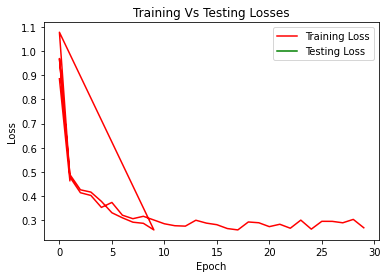

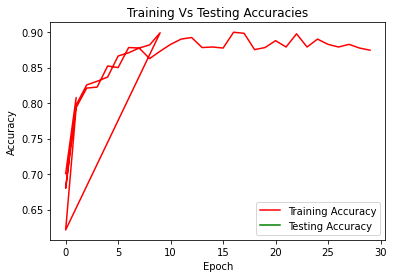

In [31]:
#Plot the train & test losses
plt.figure(1)
plt.title("Training Vs Testing Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Testing Loss")
plt.legend()
plt.show()

#Plot the accuracies in train & test
plt.figure(2)
plt.title("Training Vs Testing Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train,train_acc,color = 'r', label="Training Accuracy")
plt.plot(epoch_counter_val,val_acc,color = 'g', label="Testing Accuracy")
plt.legend()
plt.show()

# Testing Accuracy

Accuracy of the network on the test images: 88 %
Accuracy of NOFRACTURES : 95 %
Accuracy of WITHFRACTURES : 76 %
[[830  42]
 [109 366]]


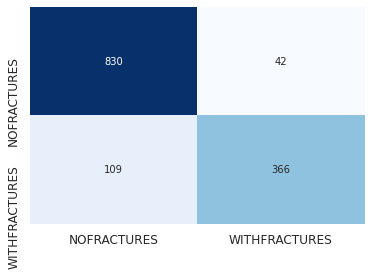

In [37]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['XRAY']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

#Class wise testing accuracy
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['XRAY']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))


#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(2)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['XRAY']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues") 